In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install visualkeras

     |████████████████████████████████| 992 kB 15.0 MB/s 


In [ ]:
#importando bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import Callback,ModelCheckpoint
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.backend as K

from keras.models import Sequential, Model

from typeguard import typechecked
from typing import Optional
import visualkeras

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

TRATAMENTO DE DADOS

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Colab Notebooks/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

Found 4098 images belonging to 4 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Colab Notebooks/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 1023 images belonging to 4 classes.


In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Colab Notebooks/Alzheimer_s Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 1279 images belonging to 4 classes.


CONSTRUINDO MODELO RESNET50

In [ ]:
Res_Model1 = ResNet50(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

In [ ]:
Res_Model1.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

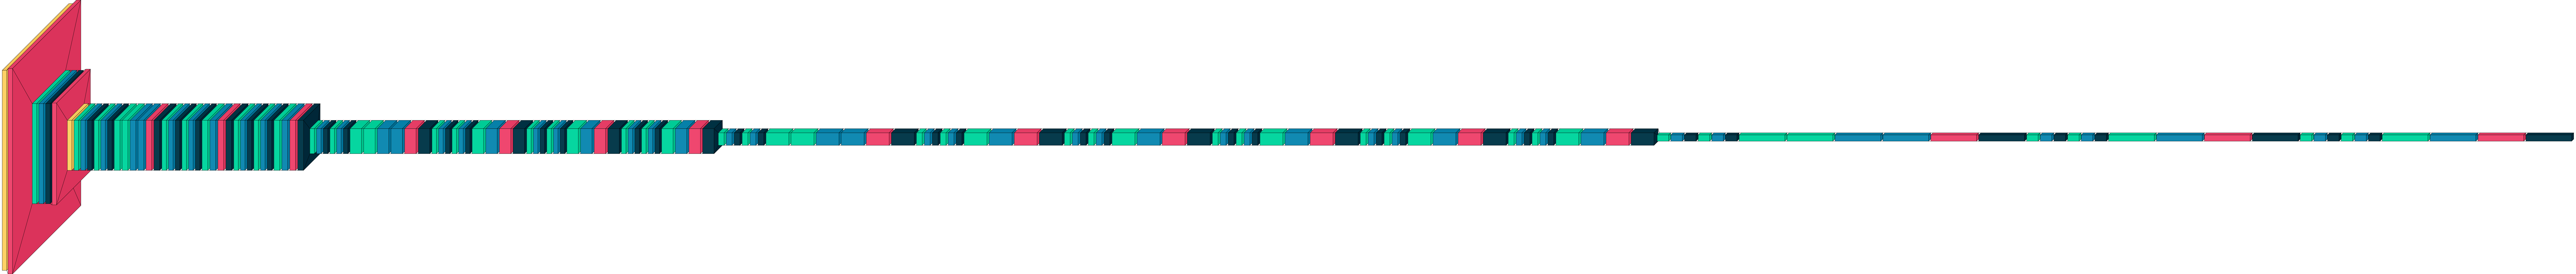

In [ ]:
visualkeras.layered_view(Res_Model1)

In [ ]:
last_output= Res_Model1.layers[-1].output

last_output= Flatten()(last_output)

pretrained_model= Model(Res_Model1.input, last_output)

In [ ]:
x= Dense(units=128, activation="relu")(last_output)
x=Dropout(0.2)(x)

x= Dense(units=32, activation="relu")(x)
x=Dropout(0.2)(x)

x= Dense(units=1, activation="sigmoid")(x)

Res_Model= Model(pretrained_model.input, x)

Res_Model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
for layer in Res_Model.layers:
    layer.trainable=False

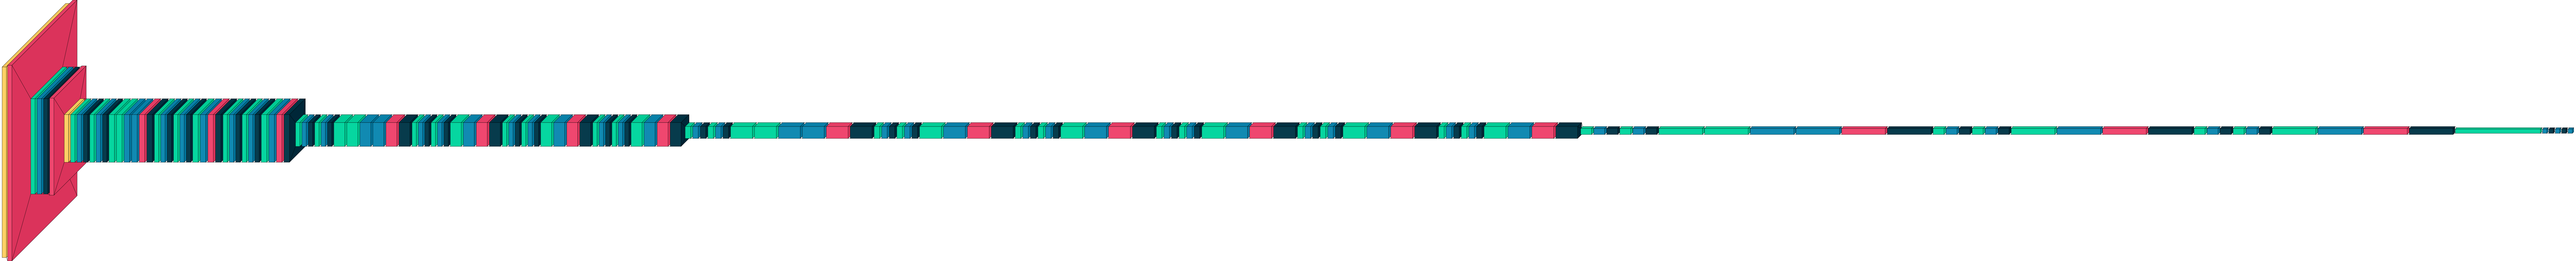

In [ ]:
visualkeras.layered_view(Res_Model)

METRICAS DE AVALIAÇÃO

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='acuracia'),
      tf.keras.metrics.Precision(name='precisão'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) # Quando rodar por 50 folds

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

TESTE DO MODELO

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 20,
                        verbose = 1,
                        callbacks=lr_scheduler)

Epoch 1/20
  8/129 [>.............................] - ETA: 13:57 - loss: 1.2315 - acuracia: 0.7334 - precisão: 0.4220 - recall: 0.1797 - auc: 0.7168 - f1_score: 0.2502

GRÁFICOS COM MÉTRICAS DO MODELO

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" Metricas do modelo ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('Acuracia')
    ax1.set_xlabel('Folds')
    ax1.set_ylabel('Acuracia')
    ax1.legend(['Treino', 'Teste'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('Loss')
    ax2.set_xlabel('Folds')
    ax2.set_ylabel('Loss')
    ax1.legend(['Treino', 'Teste'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('AUC')
    ax3.set_xlabel('Folds')
    ax3.set_ylabel('AUC')
    ax1.legend(['Treino', 'Teste'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('Precisão')
    ax4.set_xlabel('Folds')
    ax4.set_ylabel('Precisão')
    ax1.legend(['Treino', 'Teste'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('F1-score')
    ax5.set_xlabel('Folds')
    ax5.set_ylabel('F1 score')
    ax1.legend(['Treino', 'Teste'])


    plt.show()
    

Train_Val_Plot(history.history['acuracia'],history.history['val_acuracia'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precisão'],history.history['val_precisão'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [ ]:
scores = model.evaluate(test_dataset)

MÉDIAS ALCANÇADAS COM O MODELO

In [ ]:
print("Accuracia = ", scores[1])
print("Precisão = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

In [ ]:
kpred = model.predict(test_dataset)

In [ ]:
pred = kpred.tolist()
predictions = []
for i in pred:
  predictions.append(i.index(max(i)))

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [ ]:
#Previsão dos dados de teste

pred_labels = dense_model.predict(test_data)

In [ ]:
#Como os rótulos são arrays softmax, precisamos arredondar para tê-los na forma de 0s e 1s,
#semelhante aos test_labels
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

In [ ]:
## plotar matriz de confusão
y_preds = model.predict(x_test)
y_preds = np.argmax(y_preds, axis=1)
y_trues = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_trues, y_preds)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)

ax.set(
    xticklabels=list(label_to_class.keys()),
    yticklabels=list(label_to_class.keys()),
    title='Matriz de Confusão',
    ylabel='Verdadeiros',
    xlabel='Falsos'
)
params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()